# Data_Cleaning, Data_Engineering, Data_Visualizations

## Sentiment Group

### 1. Load the Semi-Clean Input

**Explanation:** We load the file we just saved (stock_engineered_1.csv) to continue the pipeline.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# Load the Stock-Engineered Data
input_path = os.path.join(semi_clean_dir, "stock_engineered_1.csv")
df = pd.read_csv(input_path)

# Ensure date is datetime (pandas sometimes loses this on CSV reload)
df['date'] = pd.to_datetime(df['date'])

print(f"Data Loaded. Shape: {df.shape}")
df.head(3)

Data Loaded. Shape: (24255, 19)


date      volume       open       high        low      close  \
0 2010-03-16  15411100.0  39.587097  39.869156  39.457504  39.770054   
1 2010-03-17  15822600.0  39.930141  40.539993  39.876778  40.387531   
2 2010-03-18  11119500.0  40.326546  40.334167  39.770054  40.181705   

   adj close ticker  sentiment_score  n_articles   pos_avg   neg_avg  \
0  27.808268    COP         0.832790         1.0  0.876238  0.043448   
1  28.240026    COP         0.681747         2.0  0.712619  0.030872   
2  28.096098    COP         0.087004         4.0  0.297768  0.210764   

    neu_avg        MA7       MA50        RSI  Log_Returns  Close_to_MA7  \
0  0.080314  39.188516  38.402764  83.745506     0.010017      1.014840   
1  0.256508  39.433546  38.408862  86.448540     0.015407      1.024192   
2  0.491468  39.636105  38.410082  86.854394    -0.005109      1.013765   

   Close_to_MA50  
0       1.035604  
1       1.051516  
2       1.046124

### 2. Engineer Sentiment Features

**Explanation:** We calculate the 7-day and 30-day Moving Averages for sentiment_score. We also calculate Sentiment_Vol (Volatility) to see how "unstable" the news is.

In [13]:
# Group by ticker to ensure calculations don't bleed across companies
# 1. Weekly Sentiment Trend (7-day MA)
df['Sent_MA7'] = df.groupby('ticker')['sentiment_score'].transform(lambda x: x.rolling(window=7).mean())

# 2. Monthly Sentiment Trend (30-day MA)
df['Sent_MA30'] = df.groupby('ticker')['sentiment_score'].transform(lambda x: x.rolling(window=30).mean())

# 3. Sentiment Volatility (Standard Deviation over 7 days)
# High values = Conflicting news (uncertainty); Low values = Consistent news
df['Sent_Vol7'] = df.groupby('ticker')['sentiment_score'].transform(lambda x: x.rolling(window=7).std())

# Drop the new NaNs created by the 30-day window
df_clean_sent = df.dropna().copy()

print("Sentiment Engineering Complete.")
print(f"New Shape: {df_clean_sent.shape}")
df_clean_sent[['date', 'ticker', 'sentiment_score', 'Sent_MA7', 'Sent_MA30']].head()

Sentiment Engineering Complete.
New Shape: (24052, 22)


date ticker  sentiment_score  Sent_MA7  Sent_MA30
29 2010-04-27    COP         0.000000 -0.162053   0.013629
30 2010-04-28    COP         0.084899 -0.149924  -0.011301
31 2010-04-29    COP        -0.020716 -0.152884  -0.034716
32 2010-04-30    COP         0.000000 -0.106895  -0.037617
33 2010-05-03    COP         0.000000  0.019581  -0.037325

### 3. Save the Output

**Explanation:** Saving the file as stock_sentiment_engineered_2.csv.

In [16]:
output_path = os.path.join(semi_clean_dir, "stock_sentiment_engineered_2.csv")
df_clean_sent.to_csv(output_path, index=False)
print(f"Saved processed data to: {output_path}")

Saved processed data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\stock_sentiment_engineered_2.csv


### 4. Dual-Axis Plotting (Overlay)

**Explanation:** 
- This is the complex plotting code.

- **Ax1** (Left Axis): Plots the Stock Price (Navy Blue).

- **Ax2** (Right Axis): Plots the Sentiment MA7 (Green).

- Why MA7? Raw sentiment is too jagged to see the correlation visually. The 7-day MA usually reveals the relationship better.

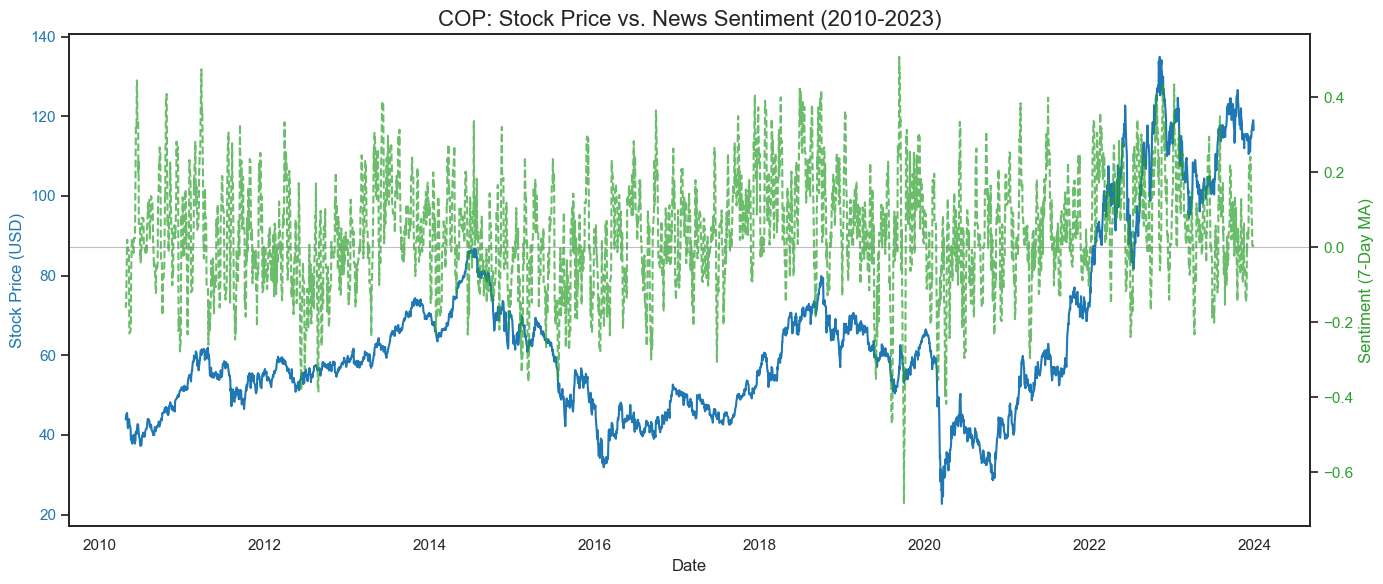

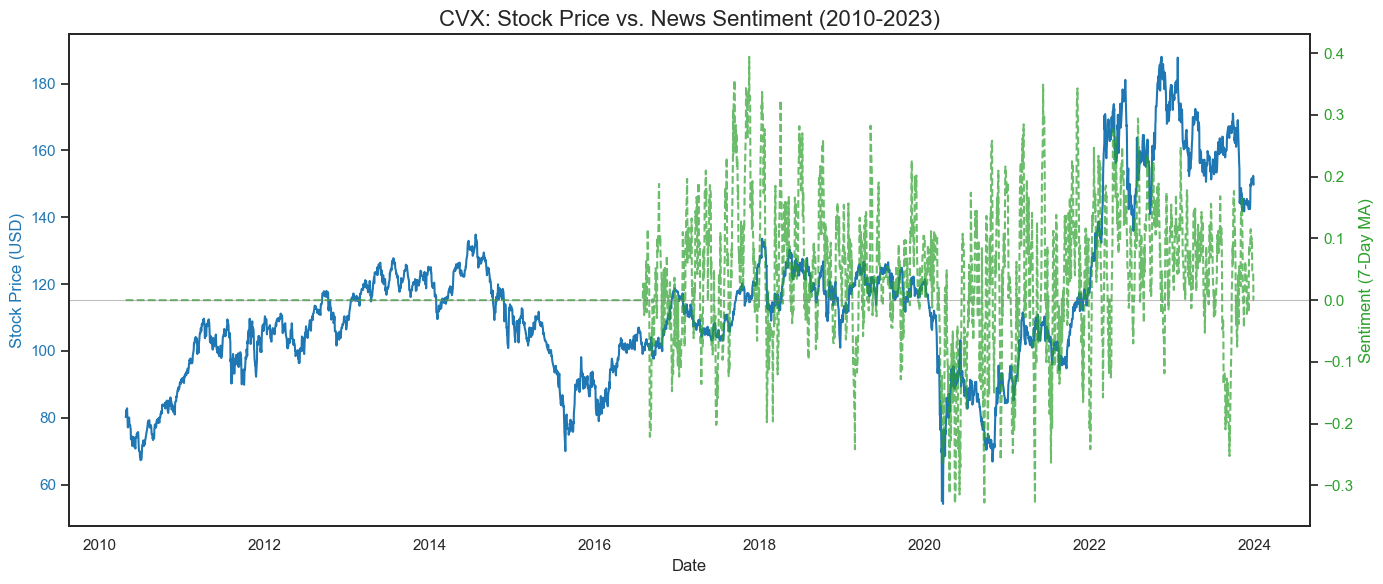

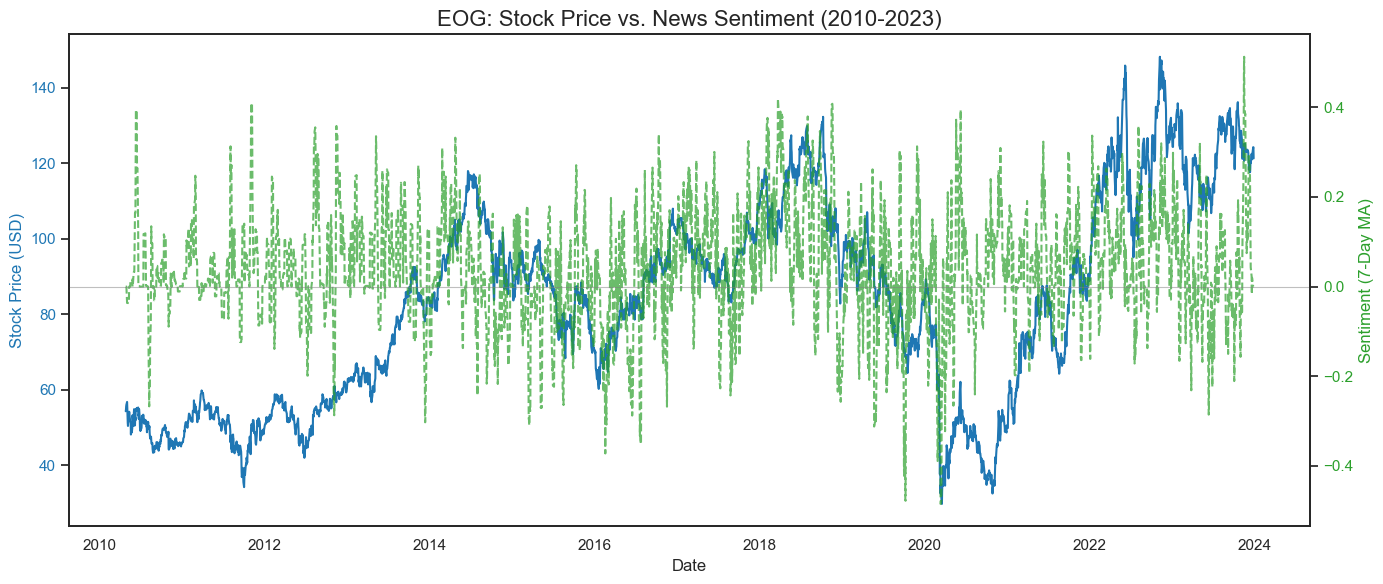

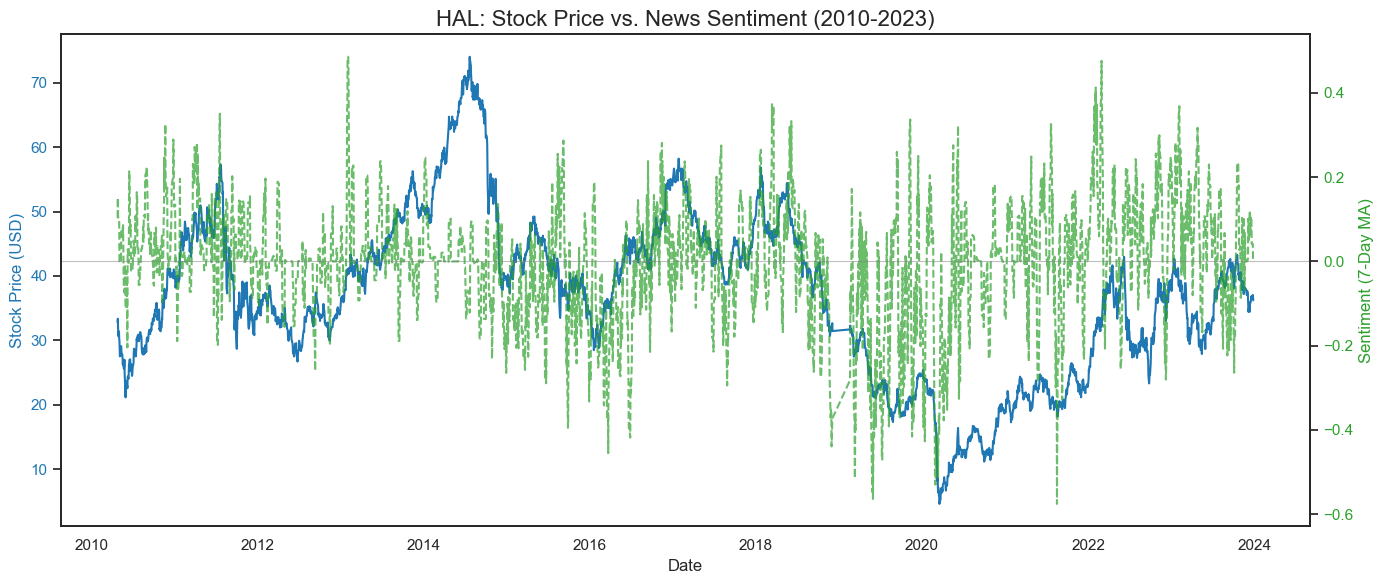

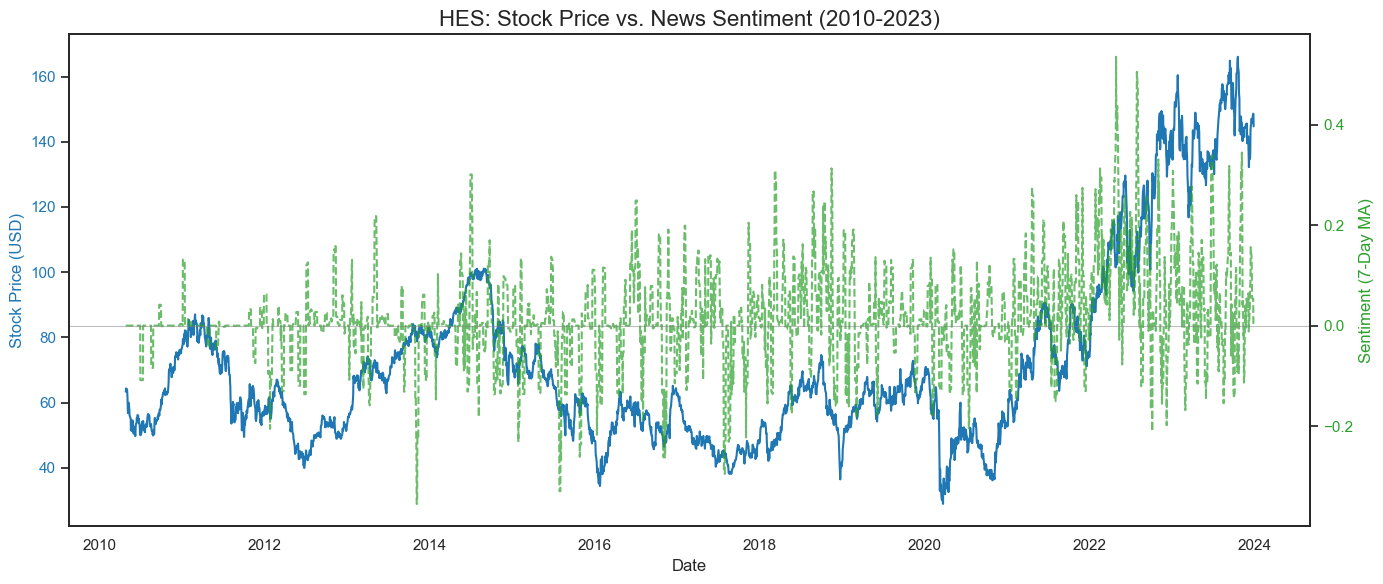

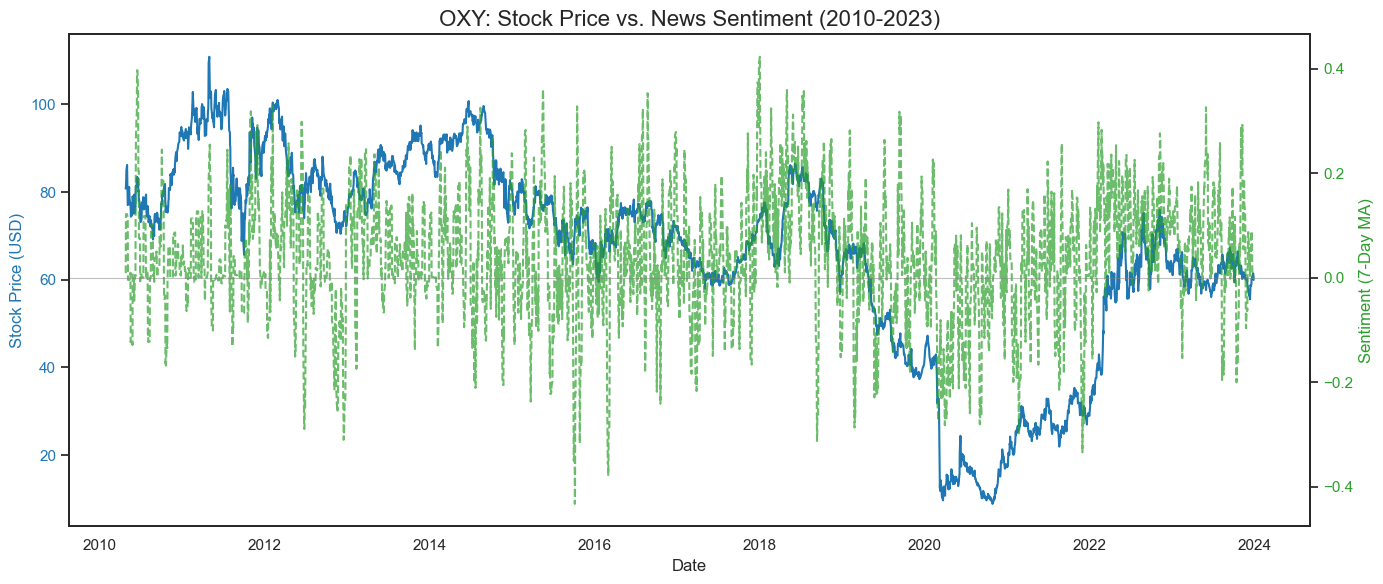

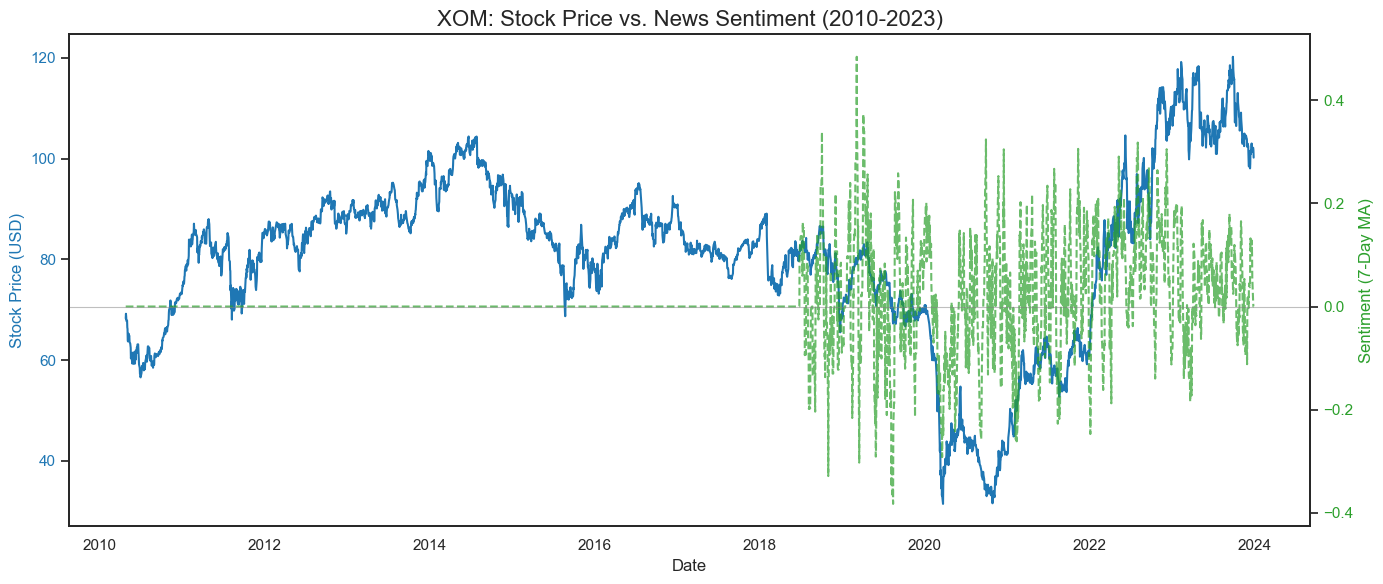

In [19]:
tickers = df_clean_sent['ticker'].unique()
sns.set(style="white") # Cleaner background for dual-axis

for t in tickers:
    subset = df_clean_sent[df_clean_sent['ticker'] == t]
    
    # Create Figure and the first axis (Stock Price)
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Plot Stock Price on Left Axis
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price (USD)', color=color, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color, label='Close Price', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create second axis (Sentiment) sharing the same x-axis
    ax2 = ax1.twinx()  
    
    # Plot Sentiment MA7 on Right Axis
    color = 'tab:green'
    ax2.set_ylabel('Sentiment (7-Day MA)', color=color, fontsize=12)
    # We use a slight transparency (alpha=0.6) so it doesn't block the price line
    ax2.plot(subset['date'], subset['Sent_MA7'], color=color, label='Sentiment (MA7)', linestyle='--', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add a zero line for sentiment (Neutral line)
    ax2.axhline(0, color='grey', linewidth=0.8, alpha=0.5)

    plt.title(f"{t}: Stock Price vs. News Sentiment (2010-2023)", fontsize=16)
    fig.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

### 5. Finding the sentiment data quality

**Explanation:**
The diagnostic cell below tells us:
- True Start Date: When does the news actually start flowing for each ticker?

- Sparsity: What percentage of days are actually "Zero-Imputed"?

In [21]:
# Sentiment Health Check
print("--- Sentiment Data Availability Report ---")
print(f"{'Ticker':<8} | {'First Active News Date':<22} | {'% Days with News':<15} | {'Total Articles'}")
print("-" * 70)

for t in df_clean_sent['ticker'].unique():
    subset = df_clean_sent[df_clean_sent['ticker'] == t]
    
    # Filter for days where we actually had articles (not 0-filled)
    active_days = subset[subset['n_articles'] > 0]
    
    if len(active_days) > 0:
        first_active = active_days['date'].min().strftime('%Y-%m-%d')
        percent_active = (len(active_days) / len(subset)) * 100
        total_articles = active_days['n_articles'].sum()
    else:
        first_active = "NEVER"
        percent_active = 0.0
        total_articles = 0
        
    print(f"{t:<8} | {first_active:<22} | {percent_active:>14.1f}% | {int(total_articles)}")

--- Sentiment Data Availability Report ---
Ticker   | First Active News Date | % Days with News | Total Articles
----------------------------------------------------------------------
COP      | 2010-04-28             |           74.2% | 6469
CVX      | 2016-08-03             |           51.4% | 8093
EOG      | 2010-05-03             |           59.0% | 4782
HAL      | 2010-05-03             |           62.5% | 6321
HES      | 2010-07-01             |           30.5% | 1706
OXY      | 2010-04-28             |           68.6% | 7150
XOM      | 2018-06-27             |           34.9% | 6853


### 6. Define Groups and Calculate Donor Proxy

**Explanation:** We define our "Source of Truth" (Donors) and our "Target" (Patients). We then calculate the daily average sentiment only using the Donors. This ensures XOM's zeros don't contaminate the average we use to fix XOM.

In [23]:
# --- STEP 1: Define Patient vs. Donor Lists ---
# Donors: Tickers with consistent news flow (>50% coverage). We trust their zeros.
donors = ['COP', 'HAL', 'OXY', 'EOG']

# Patients: Tickers with systematic missingness or high sparsity. We do NOT trust their zeros.
patients = ['XOM', 'CVX', 'HES']

print(f"Donor Tickers (Source of Truth): {donors}")
print(f"Patient Tickers (Receiving Imputation): {patients}")

# --- STEP 2: Calculate Sector Average from DONORS ONLY ---
# Filter to only look at Donors with active news
donor_df = df[df['ticker'].isin(donors) & (df['n_articles'] > 0)]

# Calculate the daily mean of the donors (The "Energy Sector Sentiment")
sector_daily_sentiment = donor_df.groupby('date')['sentiment_score'].mean()

# Fill days where even donors are silent with 0.0 (True Neutral)
sector_daily_sentiment = sector_daily_sentiment.fillna(0.0)

print("Sector Proxy Calculated.")

Donor Tickers (Source of Truth): ['COP', 'HAL', 'OXY', 'EOG']
Patient Tickers (Receiving Imputation): ['XOM', 'CVX', 'HES']
Sector Proxy Calculated.


### 7. Apply Surgical Imputation

**Explanation:** We apply the logic: If you are a Patient and have no news, take the Sector Average. Otherwise (if you are a Donor, or a Patient with real news), keep your original data.

In [28]:
# --- STEP 3: Surgical Imputation Function ---
def surgical_imputation(row):
    # Condition: If ticker is a PATIENT and has NO news
    if row['ticker'] in patients and row['n_articles'] == 0:
        # Impute with the Sector Average for that date
        return sector_daily_sentiment.get(row['date'], 0.0)
    
    # Condition: If ticker is a PATIENT but HAS news
    elif row['ticker'] in patients and row['n_articles'] > 0:
        # Keep its own real data (don't overwrite real news!)
        return row['sentiment_score']

    # Condition: If ticker is a DONOR
    else:
        # Keep original score (even if 0, because donor zeros are likely "True Silence")
        return row['sentiment_score']

# Apply the function row-by-row
df['sentiment_imputed'] = df.apply(surgical_imputation, axis=1)

print("Imputation Logic Applied.")

Imputation Logic Applied.


### 8. Recalculate Feature Engineering

**Explanation:** Now that we have the sentiment_imputed column, we must re-calculate the Moving Averages and Volatility using this column, not the raw one.

In [31]:
# --- STEP 4: Recalculate Features on the NEW Column ---
# We re-run the Moving Averages on 'sentiment_imputed'

# 7-Day Trend
df['Sent_MA7'] = df.groupby('ticker')['sentiment_imputed'].transform(lambda x: x.rolling(window=7).mean())

# 30-Day Trend
df['Sent_MA30'] = df.groupby('ticker')['sentiment_imputed'].transform(lambda x: x.rolling(window=30).mean())

# Volatility (Standard Deviation)
df['Sent_Vol7'] = df.groupby('ticker')['sentiment_imputed'].transform(lambda x: x.rolling(window=7).std())

# Clean up NaNs created by rolling windows
df_surgical = df.dropna().copy()

print("Feature Engineering Updated.")
print(f"Final Dataset Shape: {df_surgical.shape}")

Feature Engineering Updated.
Final Dataset Shape: (24052, 23)


### 9. Save the Final "Stock + Sentiment" Dataset

**Explanation:** Saving the checkpoint before we start merging macros.

In [34]:
# import os

# output_path1 = os.path.join(semi_clean_dir, "stock_sentiment_engineered_2.csv")
# output_path2 = os.path.join(semi_clean_dir, "stock_sentiment_engineered_imput_2.csv")

# print("len(path1) =", len(output_path1))
# print(output_path1)
# print("len(path2) =", len(output_path2))
# print(output_path2)

# print("dir exists?", os.path.isdir(semi_clean_dir))


In [36]:
output_path = os.path.join(semi_clean_dir, "stock_senti_engineered_imputed_2.csv")
df_surgical.to_csv(output_path, index=False)
print(f"Saved processed data to: {output_path}")

Saved processed data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\stock_senti_engineered_imputed_2.csv


### 10. Dual-Axis Plotting (Updated)

**Explanation:** This plots the Stock Price vs. the New Imputed Sentiment (MA7).
- Patients (XOM, CVX, HES): Should now have a volatile (wavy) green line going all the way back to 2010.

- Donors (COP, OXY): Should look exactly the same as before.

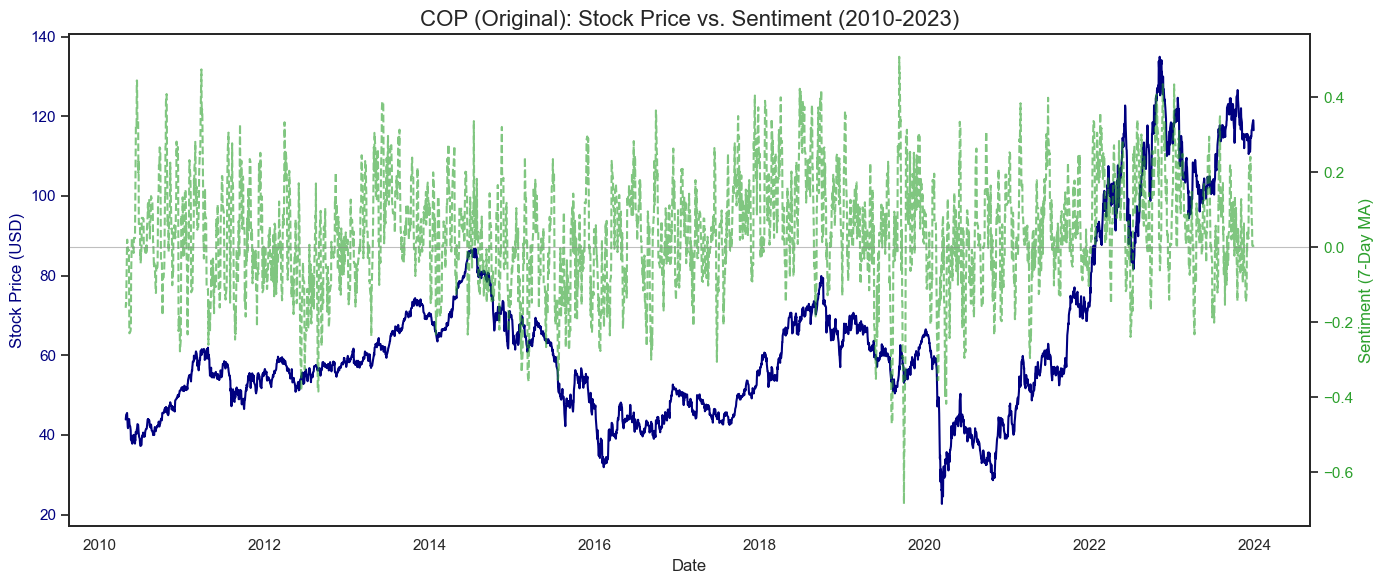

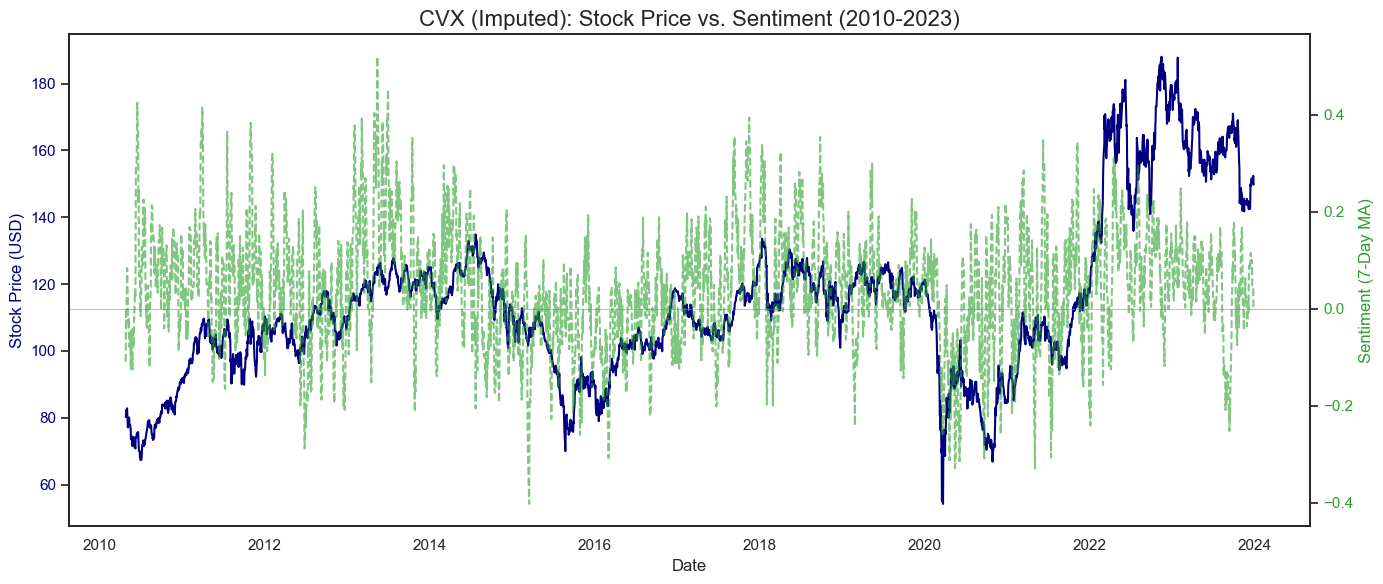

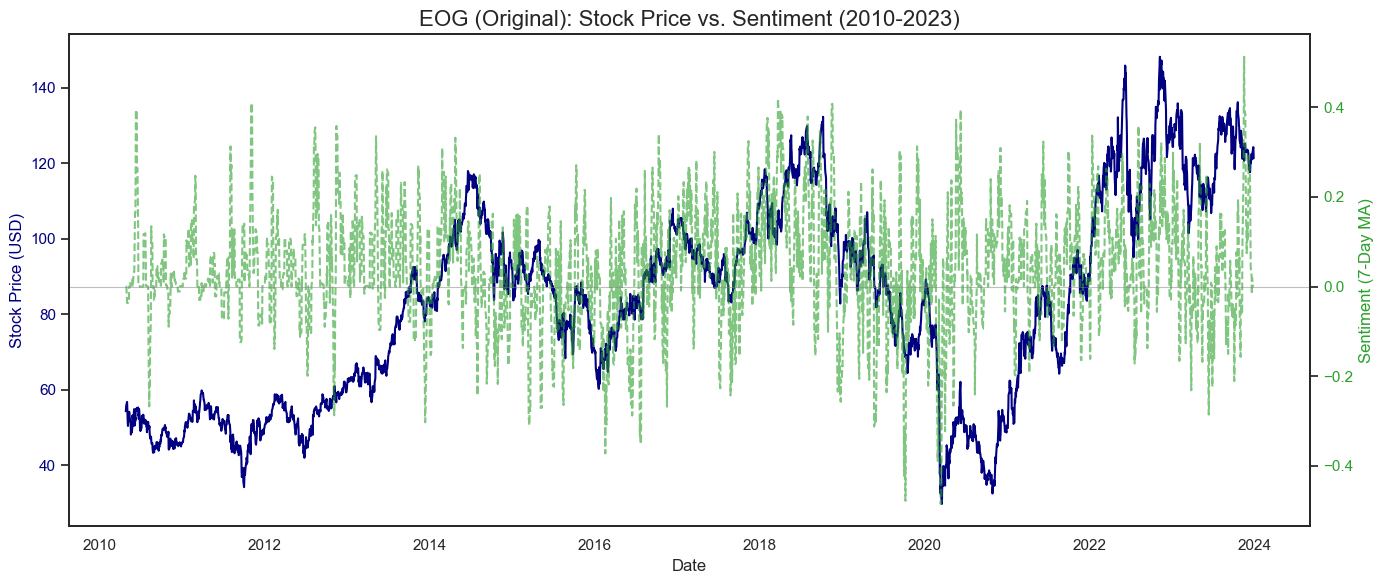

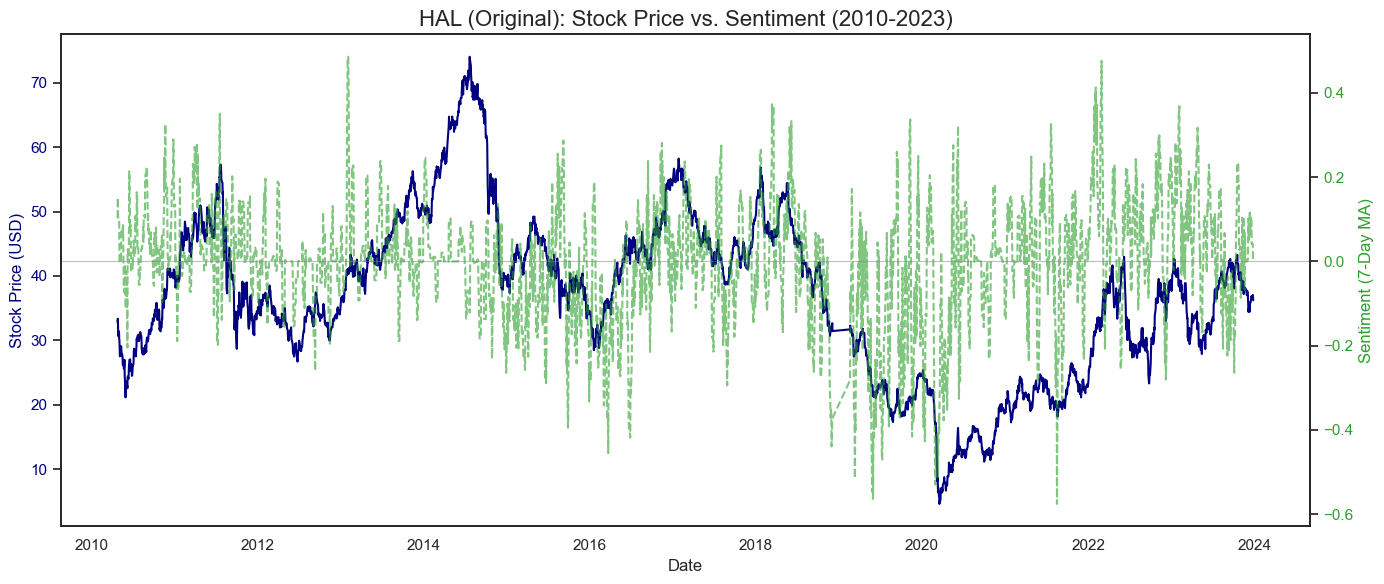

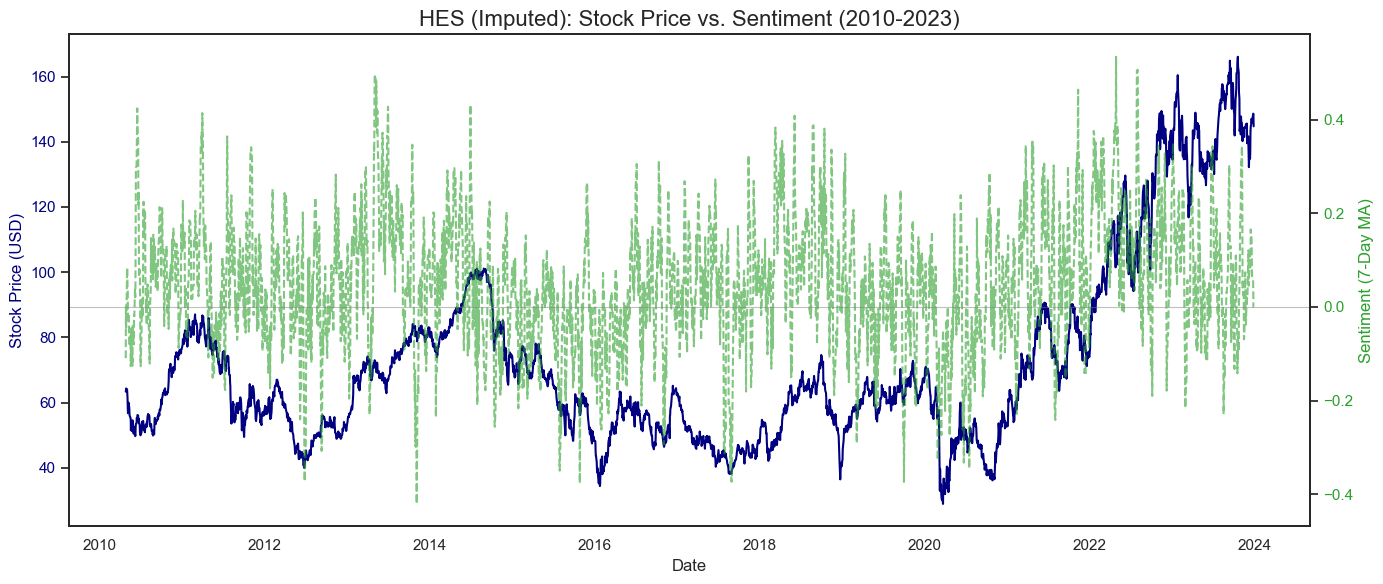

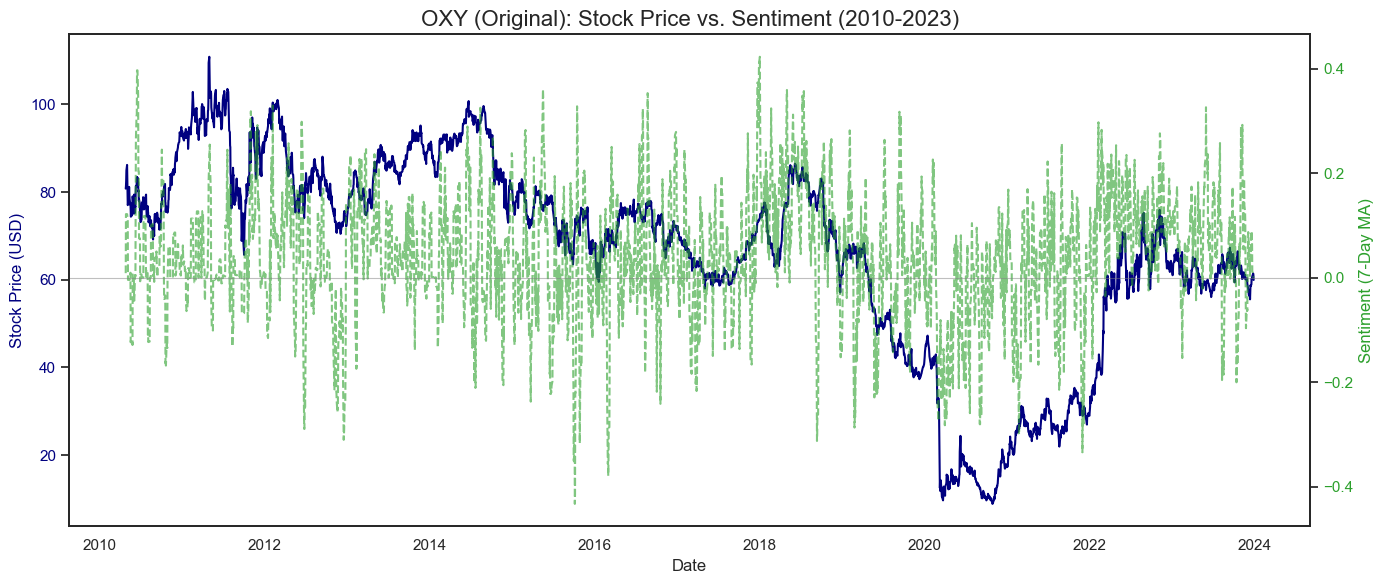

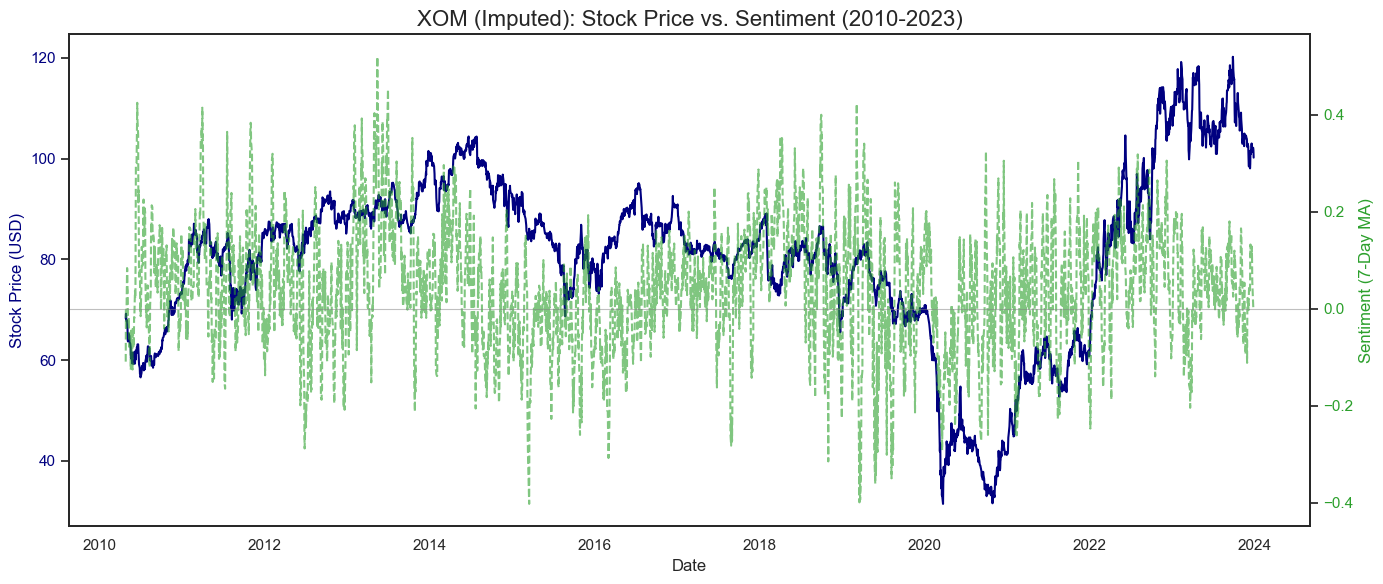

In [39]:
# Set style
sns.set(style="white")

tickers = df_surgical['ticker'].unique()

for t in tickers:
    subset = df_surgical[df_surgical['ticker'] == t]
    
    # Determine if Ticker is Patient or Donor for Title
    status = "(Imputed)" if t in patients else "(Original)"
    
    # Create Figure and the first axis (Stock Price)
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Plot Stock Price on Left Axis
    color_price = 'navy'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price (USD)', color=color_price, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color_price, label='Close Price', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(False) # Turn off grid for ax1 to keep it clean
    
    # Create second axis (Sentiment) sharing the same x-axis
    ax2 = ax1.twinx()  
    
    # Plot Sentiment MA7 on Right Axis
    # Using 'tab:green' to denote the Sentiment
    color_sent = 'tab:green'
    ax2.set_ylabel('Sentiment (7-Day MA)', color=color_sent, fontsize=12)
    ax2.plot(subset['date'], subset['Sent_MA7'], color=color_sent, label='Sentiment (MA7)', linestyle='--', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color_sent)
    
    # Add a zero line for sentiment
    ax2.axhline(0, color='grey', linewidth=0.8, alpha=0.5)

    plt.title(f"{t} {status}: Stock Price vs. Sentiment (2010-2023)", fontsize=16)
    fig.tight_layout()
    plt.show()